In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
#balance_method = "weight"
balance_method = "bagging"

DEFAULT_PARAMS = {
    'objective': 'binary',
    'boosting':'dart',
    'metric': 'None',
    'learning_rate': 0.005,
    'max_bin': 63,
    'num_leaves': 7,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,
    #'bagging_freq': 1,
    #'pos_bagging_fraction': 1,
    #'neg_bagging_fraction': 0.21218074656188604,
    'feature_fraction': 0.75,
    'lambda_l1': 0.00020196676966216634,
    'lambda_l2': 2.3627262174517976e-09,
    'min_data_in_leaf': 13,
    'min_gain_to_split': 0.0007626326850799573,
    #'num_iterations': 1591,
    'path_smooth': 2.652521741711401e-09,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

{'objective': 'binary',
 'boosting': 'dart',
 'metric': 'None',
 'learning_rate': 0.005,
 'max_bin': 63,
 'num_leaves': 7,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'feature_fraction': 0.75,
 'lambda_l1': 0.00020196676966216634,
 'lambda_l2': 2.3627262174517976e-09,
 'min_data_in_leaf': 13,
 'min_gain_to_split': 0.0007626326850799573,
 'path_smooth': 2.652521741711401e-09,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604}

In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)
    num_iterations = (
        2000 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            train_dset = lgb.Dataset(
                data=train_df.loc[:,input_cols],
                label=train_df.loc[:,"Class"].values,
                free_raw_data=False
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        #max_bin = 2**trial.suggest_int("max_bin_exp", 5, 8) - 1,
        #num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 5) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 5000),
        # regularization
        #feature_fraction = trial.suggest_float("feature_fraction", 0.3, 0.9, step=0.05),
        #min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 30),
        
        #lambda_l1 = trial.suggest_float("lambda_l1", 1e-5, 1e1, log=True),
        #lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        #path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        #min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-5, 1e1, log=True),
        
        # dart
        drop_rate = trial.suggest_float("drop_rate", 0.05, 0.3, step=0.01),
        max_drop = trial.suggest_int("max_drop", 10, 100, 5),
        skip_drop = trial.suggest_float("skip_drop", 0.2, 0.8, step=0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 23min 4s, sys: 14.3 s, total: 23min 19s
Wall time: 2min 55s


(0.2985271068432762, 0.03250519704097362)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-dart-bagging-balanced",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-dart-bagging-balanced.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=86_400, # 24 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-06-18 03:41:43,502] A new study created in RDB with name: iarc-lgbm-dart-bagging-balanced


[I 2023-06-18 03:53:14,021] Trial 0 finished with value: 0.30688860478756363 and parameters: {'drop_rate': 0.21000000000000002, 'max_drop': 65, 'num_iterations': 4349, 'skip_drop': 0.25}. Best is trial 0 with value: 0.30688860478756363.


[I 2023-06-18 03:56:51,738] Trial 1 finished with value: 0.5315100381107768 and parameters: {'drop_rate': 0.19, 'max_drop': 75, 'num_iterations': 1337, 'skip_drop': 0.2}. Best is trial 0 with value: 0.30688860478756363.


[I 2023-06-18 04:01:52,067] Trial 2 finished with value: 0.26747996063058255 and parameters: {'drop_rate': 0.27, 'max_drop': 55, 'num_iterations': 4700, 'skip_drop': 0.75}. Best is trial 2 with value: 0.26747996063058255.


[I 2023-06-18 04:03:02,478] Trial 3 finished with value: 0.26638712893262945 and parameters: {'drop_rate': 0.16999999999999998, 'max_drop': 30, 'num_iterations': 1475, 'skip_drop': 0.7}. Best is trial 3 with value: 0.26638712893262945.


[I 2023-06-18 04:05:47,268] Trial 4 finished with value: 0.23783924855387856 and parameters: {'drop_rate': 0.08, 'max_drop': 40, 'num_iterations': 2833, 'skip_drop': 0.65}. Best is trial 4 with value: 0.23783924855387856.


[I 2023-06-18 04:08:58,660] Trial 5 finished with value: 0.23700819634322126 and parameters: {'drop_rate': 0.28, 'max_drop': 95, 'num_iterations': 2601, 'skip_drop': 0.8}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:16:46,983] Trial 6 finished with value: 0.37083859961801124 and parameters: {'drop_rate': 0.26, 'max_drop': 60, 'num_iterations': 3038, 'skip_drop': 0.2}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:21:42,128] Trial 7 finished with value: 0.24361130238556364 and parameters: {'drop_rate': 0.05, 'max_drop': 45, 'num_iterations': 4575, 'skip_drop': 0.65}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:25:11,586] Trial 8 finished with value: 0.24393255168978756 and parameters: {'drop_rate': 0.16999999999999998, 'max_drop': 35, 'num_iterations': 3091, 'skip_drop': 0.55}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:30:24,444] Trial 9 finished with value: 0.2638633903128782 and parameters: {'drop_rate': 0.29, 'max_drop': 70, 'num_iterations': 2624, 'skip_drop': 0.5}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:36:43,614] Trial 10 finished with value: 0.3568679960291419 and parameters: {'drop_rate': 0.12000000000000001, 'max_drop': 100, 'num_iterations': 2243, 'skip_drop': 0.4}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:38:23,142] Trial 11 finished with value: 0.25747815491304016 and parameters: {'drop_rate': 0.08, 'max_drop': 10, 'num_iterations': 3645, 'skip_drop': 0.8}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:42:27,717] Trial 12 finished with value: 0.26214727932102627 and parameters: {'drop_rate': 0.22999999999999998, 'max_drop': 95, 'num_iterations': 2073, 'skip_drop': 0.6000000000000001}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:46:49,477] Trial 13 finished with value: 0.25110430702862013 and parameters: {'drop_rate': 0.12000000000000001, 'max_drop': 85, 'num_iterations': 3736, 'skip_drop': 0.8}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:48:07,142] Trial 14 finished with value: 0.24513474726793089 and parameters: {'drop_rate': 0.13, 'max_drop': 20, 'num_iterations': 1999, 'skip_drop': 0.7}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:54:02,167] Trial 15 finished with value: 0.2583123307481841 and parameters: {'drop_rate': 0.3, 'max_drop': 45, 'num_iterations': 3540, 'skip_drop': 0.4}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 04:58:05,175] Trial 16 finished with value: 0.24421556257086866 and parameters: {'drop_rate': 0.09, 'max_drop': 80, 'num_iterations': 2628, 'skip_drop': 0.65}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:00:44,172] Trial 17 finished with value: 0.3097674742130471 and parameters: {'drop_rate': 0.24, 'max_drop': 50, 'num_iterations': 1711, 'skip_drop': 0.5}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:01:26,815] Trial 18 finished with value: 0.28814489589930853 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 1051, 'skip_drop': 0.75}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:06:25,785] Trial 19 finished with value: 0.2486224657510026 and parameters: {'drop_rate': 0.15000000000000002, 'max_drop': 85, 'num_iterations': 2683, 'skip_drop': 0.6000000000000001}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:10:43,921] Trial 20 finished with value: 0.24931094390853134 and parameters: {'drop_rate': 0.09, 'max_drop': 25, 'num_iterations': 4021, 'skip_drop': 0.4}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:16:04,412] Trial 21 finished with value: 0.248470401503842 and parameters: {'drop_rate': 0.05, 'max_drop': 45, 'num_iterations': 4933, 'skip_drop': 0.65}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:19:04,035] Trial 22 finished with value: 0.2385409273835469 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 3271, 'skip_drop': 0.7}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:21:43,192] Trial 23 finished with value: 0.24043800124573764 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 3305, 'skip_drop': 0.75}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:23:09,063] Trial 24 finished with value: 0.24149636425953375 and parameters: {'drop_rate': 0.11, 'max_drop': 15, 'num_iterations': 2799, 'skip_drop': 0.8}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:25:54,692] Trial 25 finished with value: 0.2445582920210595 and parameters: {'drop_rate': 0.15000000000000002, 'max_drop': 60, 'num_iterations': 2300, 'skip_drop': 0.7}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:28:35,022] Trial 26 finished with value: 0.23794418528947436 and parameters: {'drop_rate': 0.1, 'max_drop': 25, 'num_iterations': 3268, 'skip_drop': 0.6000000000000001}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:30:55,090] Trial 27 finished with value: 0.2599910057767277 and parameters: {'drop_rate': 0.2, 'max_drop': 25, 'num_iterations': 2421, 'skip_drop': 0.5}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:33:13,427] Trial 28 finished with value: 0.24522836312399593 and parameters: {'drop_rate': 0.14, 'max_drop': 10, 'num_iterations': 4087, 'skip_drop': 0.6000000000000001}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:40:21,677] Trial 29 finished with value: 0.3300943339202441 and parameters: {'drop_rate': 0.22000000000000003, 'max_drop': 65, 'num_iterations': 2929, 'skip_drop': 0.30000000000000004}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:42:58,934] Trial 30 finished with value: 0.24183235675124187 and parameters: {'drop_rate': 0.1, 'max_drop': 20, 'num_iterations': 3227, 'skip_drop': 0.55}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:45:53,247] Trial 31 finished with value: 0.23926270331228672 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 3402, 'skip_drop': 0.7}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:48:39,520] Trial 32 finished with value: 0.24901099111710123 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 3913, 'skip_drop': 0.75}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:52:10,334] Trial 33 finished with value: 0.23850267511631476 and parameters: {'drop_rate': 0.1, 'max_drop': 50, 'num_iterations': 2965, 'skip_drop': 0.65}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:55:54,279] Trial 34 finished with value: 0.2572283222302758 and parameters: {'drop_rate': 0.18, 'max_drop': 55, 'num_iterations': 2490, 'skip_drop': 0.55}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 05:59:20,946] Trial 35 finished with value: 0.2394981086820572 and parameters: {'drop_rate': 0.1, 'max_drop': 50, 'num_iterations': 2902, 'skip_drop': 0.65}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:02:34,659] Trial 36 finished with value: 0.31532610111430825 and parameters: {'drop_rate': 0.16, 'max_drop': 55, 'num_iterations': 1901, 'skip_drop': 0.45}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:07:55,813] Trial 37 finished with value: 0.23997220247255413 and parameters: {'drop_rate': 0.26, 'max_drop': 70, 'num_iterations': 3121, 'skip_drop': 0.6000000000000001}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:11:36,416] Trial 38 finished with value: 0.2579523859057191 and parameters: {'drop_rate': 0.19, 'max_drop': 40, 'num_iterations': 4260, 'skip_drop': 0.75}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:15:09,800] Trial 39 finished with value: 0.24057456024689952 and parameters: {'drop_rate': 0.11, 'max_drop': 30, 'num_iterations': 3459, 'skip_drop': 0.55}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:19:16,214] Trial 40 finished with value: 0.23885303917978074 and parameters: {'drop_rate': 0.28, 'max_drop': 60, 'num_iterations': 3034, 'skip_drop': 0.65}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:21:46,843] Trial 41 finished with value: 0.23787906492215194 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2801, 'skip_drop': 0.7}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:24:06,543] Trial 42 finished with value: 0.2382341903367472 and parameters: {'drop_rate': 0.08, 'max_drop': 45, 'num_iterations': 2759, 'skip_drop': 0.75}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:25:57,793] Trial 43 finished with value: 0.23788679175157437 and parameters: {'drop_rate': 0.08, 'max_drop': 30, 'num_iterations': 2737, 'skip_drop': 0.8}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:27:18,796] Trial 44 finished with value: 0.23977541507272918 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 20, 'num_iterations': 2230, 'skip_drop': 0.75}. Best is trial 5 with value: 0.23700819634322126.


[I 2023-06-18 06:28:56,323] Trial 45 finished with value: 0.23666346107949515 and parameters: {'drop_rate': 0.08, 'max_drop': 30, 'num_iterations': 2553, 'skip_drop': 0.8}. Best is trial 45 with value: 0.23666346107949515.


[I 2023-06-18 06:30:30,526] Trial 46 finished with value: 0.23628339316283806 and parameters: {'drop_rate': 0.08, 'max_drop': 30, 'num_iterations': 2483, 'skip_drop': 0.8}. Best is trial 46 with value: 0.23628339316283806.


[I 2023-06-18 06:31:44,346] Trial 47 finished with value: 0.2428740200764204 and parameters: {'drop_rate': 0.13, 'max_drop': 35, 'num_iterations': 1757, 'skip_drop': 0.8}. Best is trial 46 with value: 0.23628339316283806.


[I 2023-06-18 06:34:12,921] Trial 48 finished with value: 0.2356447497759179 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 100, 'num_iterations': 2496, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:37:25,316] Trial 49 finished with value: 0.23649593280461534 and parameters: {'drop_rate': 0.25, 'max_drop': 100, 'num_iterations': 2473, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:40:36,961] Trial 50 finished with value: 0.2367469023991574 and parameters: {'drop_rate': 0.24, 'max_drop': 100, 'num_iterations': 2480, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:43:44,049] Trial 51 finished with value: 0.23600122591110856 and parameters: {'drop_rate': 0.26, 'max_drop': 100, 'num_iterations': 2503, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:46:54,912] Trial 52 finished with value: 0.23758668320783793 and parameters: {'drop_rate': 0.25, 'max_drop': 95, 'num_iterations': 2448, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:49:35,828] Trial 53 finished with value: 0.2361286781782449 and parameters: {'drop_rate': 0.27, 'max_drop': 100, 'num_iterations': 2155, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:52:12,068] Trial 54 finished with value: 0.2386896864143716 and parameters: {'drop_rate': 0.27, 'max_drop': 90, 'num_iterations': 2105, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:55:16,968] Trial 55 finished with value: 0.23891138056043132 and parameters: {'drop_rate': 0.3, 'max_drop': 95, 'num_iterations': 2249, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:57:42,813] Trial 56 finished with value: 0.25504477412085724 and parameters: {'drop_rate': 0.27, 'max_drop': 100, 'num_iterations': 1647, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 06:59:54,402] Trial 57 finished with value: 0.23850787564889586 and parameters: {'drop_rate': 0.22000000000000003, 'max_drop': 90, 'num_iterations': 1943, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:01:20,184] Trial 58 finished with value: 0.2602176121179139 and parameters: {'drop_rate': 0.25, 'max_drop': 90, 'num_iterations': 1295, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:04:04,804] Trial 59 finished with value: 0.2412556329096204 and parameters: {'drop_rate': 0.29, 'max_drop': 80, 'num_iterations': 2106, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:13:24,223] Trial 60 finished with value: 0.402510258963426 and parameters: {'drop_rate': 0.26, 'max_drop': 100, 'num_iterations': 2569, 'skip_drop': 0.25}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:16:26,956] Trial 61 finished with value: 0.2362103820575534 and parameters: {'drop_rate': 0.24, 'max_drop': 100, 'num_iterations': 2357, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:19:10,469] Trial 62 finished with value: 0.2357625253822473 and parameters: {'drop_rate': 0.24, 'max_drop': 95, 'num_iterations': 2315, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:22:31,423] Trial 63 finished with value: 0.23980810832528818 and parameters: {'drop_rate': 0.22999999999999998, 'max_drop': 95, 'num_iterations': 2294, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:26:32,861] Trial 64 finished with value: 0.2417403879329162 and parameters: {'drop_rate': 0.28, 'max_drop': 100, 'num_iterations': 2339, 'skip_drop': 0.7}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:28:52,079] Trial 65 finished with value: 0.23709733824880058 and parameters: {'drop_rate': 0.24, 'max_drop': 85, 'num_iterations': 2139, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:30:59,043] Trial 66 finished with value: 0.2410561085361503 and parameters: {'drop_rate': 0.25, 'max_drop': 90, 'num_iterations': 1854, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:33:00,176] Trial 67 finished with value: 0.25296854284134 and parameters: {'drop_rate': 0.21000000000000002, 'max_drop': 95, 'num_iterations': 1575, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:37:11,042] Trial 68 finished with value: 0.24278776575415176 and parameters: {'drop_rate': 0.27, 'max_drop': 100, 'num_iterations': 2375, 'skip_drop': 0.7}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:39:46,129] Trial 69 finished with value: 0.24264943062472596 and parameters: {'drop_rate': 0.28, 'max_drop': 80, 'num_iterations': 2000, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:42:54,126] Trial 70 finished with value: 0.2370056651710052 and parameters: {'drop_rate': 0.22999999999999998, 'max_drop': 90, 'num_iterations': 2632, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:46:07,448] Trial 71 finished with value: 0.2364198130902135 and parameters: {'drop_rate': 0.26, 'max_drop': 100, 'num_iterations': 2565, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:48:51,758] Trial 72 finished with value: 0.23716294398418328 and parameters: {'drop_rate': 0.26, 'max_drop': 100, 'num_iterations': 2185, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:52:10,222] Trial 73 finished with value: 0.236726755876112 and parameters: {'drop_rate': 0.22000000000000003, 'max_drop': 95, 'num_iterations': 2659, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:55:38,723] Trial 74 finished with value: 0.23788502000968748 and parameters: {'drop_rate': 0.25, 'max_drop': 95, 'num_iterations': 2383, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 07:58:58,576] Trial 75 finished with value: 0.23886205712408237 and parameters: {'drop_rate': 0.29, 'max_drop': 85, 'num_iterations': 2868, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 08:07:07,659] Trial 76 finished with value: 0.3395123412808453 and parameters: {'drop_rate': 0.24, 'max_drop': 100, 'num_iterations': 2538, 'skip_drop': 0.35000000000000003}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 08:10:31,151] Trial 77 finished with value: 0.24789247517552654 and parameters: {'drop_rate': 0.26, 'max_drop': 100, 'num_iterations': 2026, 'skip_drop': 0.7}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 08:14:14,454] Trial 78 finished with value: 0.23691673804644464 and parameters: {'drop_rate': 0.21000000000000002, 'max_drop': 95, 'num_iterations': 2705, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 08:16:18,110] Trial 79 finished with value: 0.24136773402645376 and parameters: {'drop_rate': 0.25, 'max_drop': 90, 'num_iterations': 1818, 'skip_drop': 0.8}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 08:21:10,128] Trial 80 finished with value: 0.23901685645458648 and parameters: {'drop_rate': 0.27, 'max_drop': 100, 'num_iterations': 3133, 'skip_drop': 0.75}. Best is trial 48 with value: 0.2356447497759179.


[I 2023-06-18 08:24:08,617] Trial 81 finished with value: 0.23510698304016622 and parameters: {'drop_rate': 0.09, 'max_drop': 95, 'num_iterations': 2517, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:27:00,240] Trial 82 finished with value: 0.235122487410829 and parameters: {'drop_rate': 0.09, 'max_drop': 95, 'num_iterations': 2430, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:29:43,858] Trial 83 finished with value: 0.23584460334039345 and parameters: {'drop_rate': 0.09, 'max_drop': 95, 'num_iterations': 2319, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:32:43,737] Trial 84 finished with value: 0.23859960174895556 and parameters: {'drop_rate': 0.09, 'max_drop': 95, 'num_iterations': 2321, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:34:50,900] Trial 85 finished with value: 0.2357153841848919 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2228, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:37:31,092] Trial 86 finished with value: 0.25126286079947546 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2185, 'skip_drop': 0.7}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:39:45,209] Trial 87 finished with value: 0.24623680357659702 and parameters: {'drop_rate': 0.07, 'max_drop': 90, 'num_iterations': 1945, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:41:38,389] Trial 88 finished with value: 0.23781025326938493 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 95, 'num_iterations': 2055, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:43:51,572] Trial 89 finished with value: 0.23642389557179574 and parameters: {'drop_rate': 0.11, 'max_drop': 75, 'num_iterations': 2221, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:46:56,134] Trial 90 finished with value: 0.23805873279033005 and parameters: {'drop_rate': 0.09, 'max_drop': 95, 'num_iterations': 2386, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:49:33,863] Trial 91 finished with value: 0.23603339401710044 and parameters: {'drop_rate': 0.08, 'max_drop': 90, 'num_iterations': 2445, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:51:53,789] Trial 92 finished with value: 0.23557324049015396 and parameters: {'drop_rate': 0.07, 'max_drop': 90, 'num_iterations': 2310, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:54:03,942] Trial 93 finished with value: 0.23562087967474357 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2257, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:56:41,446] Trial 94 finished with value: 0.23617258998465943 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2644, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 08:59:10,391] Trial 95 finished with value: 0.23668469772314538 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2783, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:02:13,051] Trial 96 finished with value: 0.23852618562833822 and parameters: {'drop_rate': 0.07, 'max_drop': 90, 'num_iterations': 2462, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:04:56,222] Trial 97 finished with value: 0.24099320094567955 and parameters: {'drop_rate': 0.09, 'max_drop': 80, 'num_iterations': 2275, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:07:41,044] Trial 98 finished with value: 0.23552287723183618 and parameters: {'drop_rate': 0.08, 'max_drop': 85, 'num_iterations': 2561, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:10:31,315] Trial 99 finished with value: 0.2366729440554329 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2857, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:17:53,696] Trial 100 finished with value: 0.46373229822836093 and parameters: {'drop_rate': 0.09, 'max_drop': 80, 'num_iterations': 2565, 'skip_drop': 0.2}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:20:29,617] Trial 101 finished with value: 0.23595548217284892 and parameters: {'drop_rate': 0.08, 'max_drop': 90, 'num_iterations': 2418, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:22:50,990] Trial 102 finished with value: 0.23558585828564932 and parameters: {'drop_rate': 0.1, 'max_drop': 85, 'num_iterations': 2253, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:25:13,973] Trial 103 finished with value: 0.23549790670874438 and parameters: {'drop_rate': 0.1, 'max_drop': 85, 'num_iterations': 2286, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:27:57,775] Trial 104 finished with value: 0.23945716878166481 and parameters: {'drop_rate': 0.1, 'max_drop': 80, 'num_iterations': 2275, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:30:27,678] Trial 105 finished with value: 0.2412189711911414 and parameters: {'drop_rate': 0.12000000000000001, 'max_drop': 85, 'num_iterations': 2074, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:32:39,228] Trial 106 finished with value: 0.2373610735224098 and parameters: {'drop_rate': 0.11, 'max_drop': 85, 'num_iterations': 2172, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:34:29,961] Trial 107 finished with value: 0.23849559180447114 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 1950, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:37:12,906] Trial 108 finished with value: 0.2376331034056203 and parameters: {'drop_rate': 0.12000000000000001, 'max_drop': 70, 'num_iterations': 2701, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:42:01,969] Trial 109 finished with value: 0.3169642440651994 and parameters: {'drop_rate': 0.09, 'max_drop': 75, 'num_iterations': 2333, 'skip_drop': 0.45}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:44:40,161] Trial 110 finished with value: 0.24064202245296515 and parameters: {'drop_rate': 0.08, 'max_drop': 80, 'num_iterations': 2231, 'skip_drop': 0.75}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:47:20,444] Trial 111 finished with value: 0.23536068510078056 and parameters: {'drop_rate': 0.1, 'max_drop': 90, 'num_iterations': 2392, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:49:37,997] Trial 112 finished with value: 0.23880341309315525 and parameters: {'drop_rate': 0.1, 'max_drop': 90, 'num_iterations': 2116, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:52:37,394] Trial 113 finished with value: 0.23589710191951901 and parameters: {'drop_rate': 0.11, 'max_drop': 95, 'num_iterations': 2616, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:55:08,267] Trial 114 finished with value: 0.2360453538440637 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 90, 'num_iterations': 2516, 'skip_drop': 0.8}. Best is trial 81 with value: 0.23510698304016622.


[I 2023-06-18 09:57:37,927] Trial 115 finished with value: 0.23506846062881903 and parameters: {'drop_rate': 0.1, 'max_drop': 85, 'num_iterations': 2397, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:00:39,821] Trial 116 finished with value: 0.23778764566417138 and parameters: {'drop_rate': 0.13, 'max_drop': 85, 'num_iterations': 2409, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:02:59,326] Trial 117 finished with value: 0.2359247375550203 and parameters: {'drop_rate': 0.1, 'max_drop': 85, 'num_iterations': 2237, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:06:04,294] Trial 118 finished with value: 0.2372164332143688 and parameters: {'drop_rate': 0.08, 'max_drop': 80, 'num_iterations': 2948, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:08:26,118] Trial 119 finished with value: 0.24467806274580467 and parameters: {'drop_rate': 0.07, 'max_drop': 90, 'num_iterations': 2032, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:11:06,214] Trial 120 finished with value: 0.23685121147134736 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2746, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:13:48,415] Trial 121 finished with value: 0.23598172269745266 and parameters: {'drop_rate': 0.09, 'max_drop': 95, 'num_iterations': 2305, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:19:27,922] Trial 122 finished with value: 0.2697230363190575 and parameters: {'drop_rate': 0.1, 'max_drop': 95, 'num_iterations': 4679, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:21:58,445] Trial 123 finished with value: 0.23579044360979132 and parameters: {'drop_rate': 0.08, 'max_drop': 90, 'num_iterations': 2358, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:25:14,268] Trial 124 finished with value: 0.238617589412082 and parameters: {'drop_rate': 0.12000000000000001, 'max_drop': 90, 'num_iterations': 2478, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:27:28,455] Trial 125 finished with value: 0.23821174612967286 and parameters: {'drop_rate': 0.08, 'max_drop': 90, 'num_iterations': 2153, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:29:46,824] Trial 126 finished with value: 0.23566417038661217 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2397, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:32:23,503] Trial 127 finished with value: 0.23749883249547 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2516, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:34:40,687] Trial 128 finished with value: 0.23683657163715513 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2577, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:37:25,082] Trial 129 finished with value: 0.23770782973634724 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2407, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:39:43,346] Trial 130 finished with value: 0.23597818294240697 and parameters: {'drop_rate': 0.1, 'max_drop': 85, 'num_iterations': 2217, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:42:07,222] Trial 131 finished with value: 0.23599437527643707 and parameters: {'drop_rate': 0.07, 'max_drop': 90, 'num_iterations': 2358, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:44:57,573] Trial 132 finished with value: 0.2366874118603658 and parameters: {'drop_rate': 0.08, 'max_drop': 90, 'num_iterations': 2632, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:47:24,793] Trial 133 finished with value: 0.2360116021451283 and parameters: {'drop_rate': 0.11, 'max_drop': 80, 'num_iterations': 2289, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:49:46,331] Trial 134 finished with value: 0.23687405866385497 and parameters: {'drop_rate': 0.18, 'max_drop': 95, 'num_iterations': 2107, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:52:19,073] Trial 135 finished with value: 0.2366977455914117 and parameters: {'drop_rate': 0.09, 'max_drop': 85, 'num_iterations': 2463, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:54:50,713] Trial 136 finished with value: 0.23588482360355031 and parameters: {'drop_rate': 0.08, 'max_drop': 90, 'num_iterations': 2368, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:57:16,999] Trial 137 finished with value: 0.2417307080329717 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 95, 'num_iterations': 2176, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 10:59:14,235] Trial 138 finished with value: 0.23898006103761268 and parameters: {'drop_rate': 0.16, 'max_drop': 85, 'num_iterations': 1884, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:02:14,258] Trial 139 finished with value: 0.23756272332860728 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2552, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:04:17,638] Trial 140 finished with value: 0.23774666860525373 and parameters: {'drop_rate': 0.09, 'max_drop': 90, 'num_iterations': 2015, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:06:49,206] Trial 141 finished with value: 0.23589483109407264 and parameters: {'drop_rate': 0.1, 'max_drop': 95, 'num_iterations': 2299, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:09:39,512] Trial 142 finished with value: 0.23507541276200944 and parameters: {'drop_rate': 0.09, 'max_drop': 95, 'num_iterations': 2412, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:12:08,576] Trial 143 finished with value: 0.2356514287605984 and parameters: {'drop_rate': 0.08, 'max_drop': 85, 'num_iterations': 2415, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:19:07,059] Trial 144 finished with value: 0.4431453750711771 and parameters: {'drop_rate': 0.09, 'max_drop': 85, 'num_iterations': 2449, 'skip_drop': 0.25}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:21:48,176] Trial 145 finished with value: 0.23534368571464037 and parameters: {'drop_rate': 0.07, 'max_drop': 95, 'num_iterations': 2627, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:24:59,195] Trial 146 finished with value: 0.23577044197855393 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2721, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:27:18,910] Trial 147 finished with value: 0.23696392105255562 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2604, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:30:01,234] Trial 148 finished with value: 0.23663802301024103 and parameters: {'drop_rate': 0.08, 'max_drop': 100, 'num_iterations': 2515, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:32:22,740] Trial 149 finished with value: 0.23650802609901617 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 95, 'num_iterations': 2407, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:35:46,653] Trial 150 finished with value: 0.23655557057924909 and parameters: {'drop_rate': 0.07, 'max_drop': 90, 'num_iterations': 2794, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:38:16,104] Trial 151 finished with value: 0.23644706663165327 and parameters: {'drop_rate': 0.1, 'max_drop': 95, 'num_iterations': 2266, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:41:23,913] Trial 152 finished with value: 0.23674711602103357 and parameters: {'drop_rate': 0.09, 'max_drop': 100, 'num_iterations': 2668, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:44:06,353] Trial 153 finished with value: 0.2357325626563437 and parameters: {'drop_rate': 0.11, 'max_drop': 95, 'num_iterations': 2446, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:46:34,531] Trial 154 finished with value: 0.23578006781475755 and parameters: {'drop_rate': 0.11, 'max_drop': 85, 'num_iterations': 2445, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:49:15,627] Trial 155 finished with value: 0.23570079461927482 and parameters: {'drop_rate': 0.09, 'max_drop': 90, 'num_iterations': 2512, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:55:04,532] Trial 156 finished with value: 0.27372131039470177 and parameters: {'drop_rate': 0.08, 'max_drop': 90, 'num_iterations': 4963, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 11:57:49,390] Trial 157 finished with value: 0.23605972874563824 and parameters: {'drop_rate': 0.09, 'max_drop': 90, 'num_iterations': 2566, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:00:24,155] Trial 158 finished with value: 0.23896924354964316 and parameters: {'drop_rate': 0.1, 'max_drop': 85, 'num_iterations': 2182, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:02:39,761] Trial 159 finished with value: 0.23565453192394806 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2371, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:05:19,601] Trial 160 finished with value: 0.23826164140790948 and parameters: {'drop_rate': 0.09, 'max_drop': 80, 'num_iterations': 2668, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:07:37,266] Trial 161 finished with value: 0.23522658274621935 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2383, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:13:31,880] Trial 162 finished with value: 0.42079748847693815 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2361, 'skip_drop': 0.30000000000000004}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:16:03,297] Trial 163 finished with value: 0.23598264871883853 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 90, 'num_iterations': 2522, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:18:30,096] Trial 164 finished with value: 0.23561338147633973 and parameters: {'drop_rate': 0.08, 'max_drop': 85, 'num_iterations': 2392, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:20:54,204] Trial 165 finished with value: 0.23594668412653744 and parameters: {'drop_rate': 0.08, 'max_drop': 80, 'num_iterations': 2382, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:22:56,206] Trial 166 finished with value: 0.2351436499864837 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2270, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:25:08,482] Trial 167 finished with value: 0.23793957810699606 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2269, 'skip_drop': 0.75}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:26:54,715] Trial 168 finished with value: 0.23809085079671108 and parameters: {'drop_rate': 0.05, 'max_drop': 65, 'num_iterations': 2145, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:29:07,452] Trial 169 finished with value: 0.23629836473732957 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2310, 'skip_drop': 0.8}. Best is trial 115 with value: 0.23506846062881903.


[I 2023-06-18 12:31:32,975] Trial 170 finished with value: 0.234611075249458 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2609, 'skip_drop': 0.8}. Best is trial 170 with value: 0.234611075249458.


[I 2023-06-18 12:33:57,037] Trial 171 finished with value: 0.23444495563532208 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2589, 'skip_drop': 0.8}. Best is trial 171 with value: 0.23444495563532208.


[I 2023-06-18 12:36:20,928] Trial 172 finished with value: 0.23580777747112308 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2634, 'skip_drop': 0.8}. Best is trial 171 with value: 0.23444495563532208.


[I 2023-06-18 12:38:56,014] Trial 173 finished with value: 0.23767239514563054 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2832, 'skip_drop': 0.8}. Best is trial 171 with value: 0.23444495563532208.


[I 2023-06-18 12:41:18,750] Trial 174 finished with value: 0.23440777951578542 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2572, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 12:46:00,319] Trial 175 finished with value: 0.27918607128352824 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2746, 'skip_drop': 0.5}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 12:48:49,049] Trial 176 finished with value: 0.23698572032545948 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2575, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 12:51:08,798] Trial 177 finished with value: 0.23448519719960415 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2521, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 12:53:23,497] Trial 178 finished with value: 0.23596058430311045 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2610, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 12:56:05,094] Trial 179 finished with value: 0.2375280804762355 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2495, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 12:58:34,892] Trial 180 finished with value: 0.23517322408520053 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2686, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:01:05,228] Trial 181 finished with value: 0.23530885360149761 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 70, 'num_iterations': 2666, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:03:37,551] Trial 182 finished with value: 0.23545464336219063 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 70, 'num_iterations': 2715, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:06:06,194] Trial 183 finished with value: 0.23704651628904272 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 60, 'num_iterations': 2864, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:08:40,993] Trial 184 finished with value: 0.23750391712685634 and parameters: {'drop_rate': 0.05, 'max_drop': 70, 'num_iterations': 2922, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:11:13,174] Trial 185 finished with value: 0.23530165339483855 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 70, 'num_iterations': 2698, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:13:38,606] Trial 186 finished with value: 0.23570696208575234 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 65, 'num_iterations': 2705, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:16:27,866] Trial 187 finished with value: 0.23721266529137147 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 70, 'num_iterations': 2989, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:18:52,118] Trial 188 finished with value: 0.2362842910331544 and parameters: {'drop_rate': 0.05, 'max_drop': 70, 'num_iterations': 2748, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:21:39,755] Trial 189 finished with value: 0.2367332471574755 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 65, 'num_iterations': 2800, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:23:57,539] Trial 190 finished with value: 0.23640821169845153 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2648, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:26:31,406] Trial 191 finished with value: 0.23526240357625397 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2568, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:29:12,497] Trial 192 finished with value: 0.23587545131459184 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2683, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:31:34,349] Trial 193 finished with value: 0.23476572851338426 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2555, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:33:55,205] Trial 194 finished with value: 0.23535846521953815 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2589, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:36:15,839] Trial 195 finished with value: 0.2353753879331691 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2588, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:38:39,809] Trial 196 finished with value: 0.23575357260832047 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2630, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:40:51,864] Trial 197 finished with value: 0.23588059679316636 and parameters: {'drop_rate': 0.05, 'max_drop': 70, 'num_iterations': 2568, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:43:27,390] Trial 198 finished with value: 0.23649195615561477 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2790, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:45:55,956] Trial 199 finished with value: 0.23635913978333306 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2709, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:48:22,297] Trial 200 finished with value: 0.23539536928798285 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2533, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:50:47,689] Trial 201 finished with value: 0.23539995797608845 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2526, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:53:13,932] Trial 202 finished with value: 0.23544428604304257 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2541, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:55:36,272] Trial 203 finished with value: 0.2353214820373867 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2494, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 13:57:46,605] Trial 204 finished with value: 0.23603232483454206 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2474, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:00:52,186] Trial 205 finished with value: 0.2370100161376494 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2603, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:03:16,094] Trial 206 finished with value: 0.2357189564962992 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2629, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:05:32,702] Trial 207 finished with value: 0.23459055719767832 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2450, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:07:40,952] Trial 208 finished with value: 0.23594231156567233 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2448, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:09:59,322] Trial 209 finished with value: 0.23474058271585757 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2483, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:12:09,196] Trial 210 finished with value: 0.23603635427622546 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2477, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:14:34,223] Trial 211 finished with value: 0.23447999658975124 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2591, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:17:03,958] Trial 212 finished with value: 0.2351309179474731 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2670, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:19:34,232] Trial 213 finished with value: 0.23513329546612943 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2669, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:22:04,837] Trial 214 finished with value: 0.23545479912788267 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2698, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:24:45,338] Trial 215 finished with value: 0.23662924313986763 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2869, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:27:25,372] Trial 216 finished with value: 0.23626788880431904 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2664, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:30:21,600] Trial 217 finished with value: 0.23559048734030455 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2774, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:32:49,734] Trial 218 finished with value: 0.2358451709965815 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2485, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:37:28,196] Trial 219 finished with value: 0.30236377376076085 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2562, 'skip_drop': 0.45}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:39:56,759] Trial 220 finished with value: 0.23505524289801127 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2660, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:42:26,414] Trial 221 finished with value: 0.23517138330657952 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2666, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:44:59,276] Trial 222 finished with value: 0.23578422859617187 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2729, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:47:28,389] Trial 223 finished with value: 0.23506604416573598 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2661, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:50:05,210] Trial 224 finished with value: 0.2361330862790819 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2807, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:54:14,468] Trial 225 finished with value: 0.25276452389111975 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2670, 'skip_drop': 0.6000000000000001}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:57:06,657] Trial 226 finished with value: 0.23951658961729663 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 3062, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 14:59:10,561] Trial 227 finished with value: 0.23586200275066094 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 50, 'num_iterations': 2620, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:03:35,237] Trial 228 finished with value: 0.2635873742365431 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 4422, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:06:06,307] Trial 229 finished with value: 0.2380089602402396 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2767, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:08:27,854] Trial 230 finished with value: 0.23473065697892875 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2544, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:10:49,894] Trial 231 finished with value: 0.23479229713947572 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2557, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:13:10,966] Trial 232 finished with value: 0.23473065697892875 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2544, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:15:26,836] Trial 233 finished with value: 0.23454216806340086 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2442, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:17:42,323] Trial 234 finished with value: 0.23494646973616526 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2432, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:19:59,525] Trial 235 finished with value: 0.2345350892727147 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2466, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:22:08,221] Trial 236 finished with value: 0.23593344017172982 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2446, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:22:48,176] Trial 237 finished with value: 0.2823583160956636 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 1000, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:24:59,597] Trial 238 finished with value: 0.2363700959902589 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2496, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:29:31,153] Trial 239 finished with value: 0.24300847814259868 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 3772, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:31:57,100] Trial 240 finished with value: 0.23578410613105266 and parameters: {'drop_rate': 0.14, 'max_drop': 75, 'num_iterations': 2433, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:34:16,918] Trial 241 finished with value: 0.23459285481982126 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2527, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:36:38,270] Trial 242 finished with value: 0.23473660230850346 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2547, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:39:09,333] Trial 243 finished with value: 0.23506425393691846 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2539, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:41:41,525] Trial 244 finished with value: 0.23518309321792735 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2549, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:43:59,284] Trial 245 finished with value: 0.23477638428847666 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2488, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:46:28,707] Trial 246 finished with value: 0.234977382284101 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2511, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:48:47,501] Trial 247 finished with value: 0.2354781847727386 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2447, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:51:17,598] Trial 248 finished with value: 0.23491398293966856 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2521, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:53:48,184] Trial 249 finished with value: 0.2350235545684143 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2516, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:56:17,758] Trial 250 finished with value: 0.2350235545684143 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2516, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 15:58:47,617] Trial 251 finished with value: 0.23500550356906916 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2527, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:01:18,371] Trial 252 finished with value: 0.23505511513421254 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2538, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:03:47,079] Trial 253 finished with value: 0.23497967416040916 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2502, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:06:43,212] Trial 254 finished with value: 0.23789211972595517 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2511, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:09:16,022] Trial 255 finished with value: 0.23513897885368876 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2544, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:14:29,217] Trial 256 finished with value: 0.34002360456608377 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2468, 'skip_drop': 0.4}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:17:03,829] Trial 257 finished with value: 0.23530258900657436 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2570, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:19:31,654] Trial 258 finished with value: 0.23539919299120915 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2497, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:21:56,700] Trial 259 finished with value: 0.2388116147012363 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2362, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:24:20,836] Trial 260 finished with value: 0.23445819596965314 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2590, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:26:48,508] Trial 261 finished with value: 0.23506662109457796 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2576, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:29:03,018] Trial 262 finished with value: 0.2344973094530137 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2438, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:31:17,510] Trial 263 finished with value: 0.23498092394332326 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2428, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:33:31,043] Trial 264 finished with value: 0.23495149154032333 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2424, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:35:55,927] Trial 265 finished with value: 0.23877542633118076 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2358, 'skip_drop': 0.75}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:39:07,683] Trial 266 finished with value: 0.2476722155870009 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2397, 'skip_drop': 0.65}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:41:15,013] Trial 267 finished with value: 0.2359309106849422 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2438, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:43:35,116] Trial 268 finished with value: 0.23535312075901016 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2425, 'skip_drop': 0.8}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:46:57,650] Trial 269 finished with value: 0.26981738847963205 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2336, 'skip_drop': 0.55}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:52:24,661] Trial 270 finished with value: 0.3783854123639811 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2454, 'skip_drop': 0.35000000000000003}. Best is trial 174 with value: 0.23440777951578542.


[I 2023-06-18 16:54:48,260] Trial 271 finished with value: 0.23439191539283602 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2581, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 16:57:43,227] Trial 272 finished with value: 0.2367824665151891 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2588, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 16:59:51,571] Trial 273 finished with value: 0.23592799998328629 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2447, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:01:55,486] Trial 274 finished with value: 0.23586115990323342 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2335, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:04:27,032] Trial 275 finished with value: 0.23618635380522193 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2589, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:06:36,566] Trial 276 finished with value: 0.23592950923609002 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2468, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:08:58,283] Trial 277 finished with value: 0.23544438882612512 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2600, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:11:03,673] Trial 278 finished with value: 0.23580904718396756 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2380, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:12:01,565] Trial 279 finished with value: 0.25823659769776236 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 1303, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:14:57,786] Trial 280 finished with value: 0.23674977108460646 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2598, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:17:04,391] Trial 281 finished with value: 0.23527349215381693 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2478, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:19:17,828] Trial 282 finished with value: 0.2349146254070488 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2420, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:21:26,300] Trial 283 finished with value: 0.2353197073406508 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2363, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:23:55,436] Trial 284 finished with value: 0.234959127883529 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2593, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:26:35,686] Trial 285 finished with value: 0.23622498132895803 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2603, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:27:55,419] Trial 286 finished with value: 0.23504450097406998 and parameters: {'drop_rate': 0.05, 'max_drop': 15, 'num_iterations': 2589, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:30:01,392] Trial 287 finished with value: 0.23464982333991216 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2316, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:32:07,336] Trial 288 finished with value: 0.23465377652038286 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2315, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:34:19,745] Trial 289 finished with value: 0.2377887672739533 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2280, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:36:25,243] Trial 290 finished with value: 0.23462487061427287 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2310, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:38:29,749] Trial 291 finished with value: 0.2350969454007434 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2302, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:40:56,464] Trial 292 finished with value: 0.23629306891208937 and parameters: {'drop_rate': 0.2, 'max_drop': 85, 'num_iterations': 2249, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:43:03,917] Trial 293 finished with value: 0.23481551792543606 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2334, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:45:08,428] Trial 294 finished with value: 0.2351039493106868 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2298, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:47:05,396] Trial 295 finished with value: 0.23568490701053635 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2204, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:49:11,872] Trial 296 finished with value: 0.23467145039858386 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2319, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:51:17,656] Trial 297 finished with value: 0.23878727727346646 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2189, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:53:24,440] Trial 298 finished with value: 0.2347680133430123 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2329, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:55:31,289] Trial 299 finished with value: 0.23472665693390415 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2327, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:57:31,162] Trial 300 finished with value: 0.2352649239981173 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2232, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 17:59:37,462] Trial 301 finished with value: 0.23466034120519552 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2313, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:01:50,348] Trial 302 finished with value: 0.2376681022031679 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2285, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:03:43,695] Trial 303 finished with value: 0.2359564364582592 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2152, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:05:51,104] Trial 304 finished with value: 0.23486824072113577 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2337, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:07:59,867] Trial 305 finished with value: 0.23494674217697362 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2344, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:09:55,995] Trial 306 finished with value: 0.23565295868273828 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2199, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:13:31,784] Trial 307 finished with value: 0.27300953849974446 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2336, 'skip_drop': 0.55}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:15:41,033] Trial 308 finished with value: 0.2365146632191159 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2262, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:17:39,350] Trial 309 finished with value: 0.23987403636883353 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2110, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:19:55,633] Trial 310 finished with value: 0.23560166166211208 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2373, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:22:10,235] Trial 311 finished with value: 0.23498092394332326 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2428, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:23:10,369] Trial 312 finished with value: 0.25086118081353137 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 1440, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:25:09,225] Trial 313 finished with value: 0.23573108931208575 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2262, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:26:54,786] Trial 314 finished with value: 0.2367734694971021 and parameters: {'drop_rate': 0.05, 'max_drop': 45, 'num_iterations': 2367, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:30:33,765] Trial 315 finished with value: 0.23739631777317122 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 3173, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:32:41,122] Trial 316 finished with value: 0.2352106402194636 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2475, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:38:52,103] Trial 317 finished with value: 0.490649741272292 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2406, 'skip_drop': 0.2}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:41:05,430] Trial 318 finished with value: 0.23635395283893676 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2305, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:44:24,277] Trial 319 finished with value: 0.24335517023230233 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 3414, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:46:14,237] Trial 320 finished with value: 0.23778461339154522 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 55, 'num_iterations': 2212, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:48:23,565] Trial 321 finished with value: 0.23546714944595248 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2502, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:51:00,138] Trial 322 finished with value: 0.23797283405496436 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2384, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:52:49,818] Trial 323 finished with value: 0.23646331693778166 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2075, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:53:35,134] Trial 324 finished with value: 0.2666891622888769 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 1169, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:56:39,584] Trial 325 finished with value: 0.23774358920069327 and parameters: {'drop_rate': 0.16, 'max_drop': 90, 'num_iterations': 2739, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 18:59:03,770] Trial 326 finished with value: 0.2354507540764019 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2475, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:03:29,539] Trial 327 finished with value: 0.28060017851691904 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2609, 'skip_drop': 0.5}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:05:36,486] Trial 328 finished with value: 0.23486824259330968 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2321, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:08:11,969] Trial 329 finished with value: 0.23651466560901876 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2519, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:10:22,088] Trial 330 finished with value: 0.235668658268345 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2403, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:12:57,972] Trial 331 finished with value: 0.2358469446181247 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2656, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:17:22,232] Trial 332 finished with value: 0.3076493157768909 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2466, 'skip_drop': 0.45}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:20:40,126] Trial 333 finished with value: 0.26424422683456106 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2235, 'skip_drop': 0.6000000000000001}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:23:01,513] Trial 334 finished with value: 0.2358953935173724 and parameters: {'drop_rate': 0.05, 'max_drop': 90, 'num_iterations': 2558, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:25:25,891] Trial 335 finished with value: 0.23871594255250791 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2342, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:28:03,776] Trial 336 finished with value: 0.23576294328872988 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2631, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:30:20,049] Trial 337 finished with value: 0.23469647788010814 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2436, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:32:09,127] Trial 338 finished with value: 0.2357981568239809 and parameters: {'drop_rate': 0.05, 'max_drop': 90, 'num_iterations': 2145, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:34:34,749] Trial 339 finished with value: 0.23711563569029492 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2402, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:36:42,305] Trial 340 finished with value: 0.23467145039858386 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2319, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:38:51,113] Trial 341 finished with value: 0.2367381247417995 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2241, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:41:17,455] Trial 342 finished with value: 0.2350656608495517 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2544, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:43:57,213] Trial 343 finished with value: 0.23678021115996803 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2736, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:46:28,610] Trial 344 finished with value: 0.2375444197071418 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2466, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:49:08,811] Trial 345 finished with value: 0.23726965913498088 and parameters: {'drop_rate': 0.16999999999999998, 'max_drop': 90, 'num_iterations': 2424, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:51:19,891] Trial 346 finished with value: 0.23637108736750623 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2279, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:53:58,204] Trial 347 finished with value: 0.23576294328872988 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2631, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:56:13,435] Trial 348 finished with value: 0.23660875546686808 and parameters: {'drop_rate': 0.05, 'max_drop': 80, 'num_iterations': 2539, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 19:58:21,924] Trial 349 finished with value: 0.23560456618435974 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2385, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:00:18,446] Trial 350 finished with value: 0.23583600212212397 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2189, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:02:36,924] Trial 351 finished with value: 0.23467768626314214 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2479, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:04:52,104] Trial 352 finished with value: 0.2371616566885697 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2302, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:09:42,544] Trial 353 finished with value: 0.24938597251948388 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 4068, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:11:59,204] Trial 354 finished with value: 0.2345644815368563 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2444, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:14:06,667] Trial 355 finished with value: 0.2362033349119715 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2365, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:16:23,897] Trial 356 finished with value: 0.23472262412915712 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2437, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:18:34,745] Trial 357 finished with value: 0.23580989090698712 and parameters: {'drop_rate': 0.05, 'max_drop': 90, 'num_iterations': 2417, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:20:46,116] Trial 358 finished with value: 0.23783786622979966 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2261, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:22:48,931] Trial 359 finished with value: 0.23536753591058995 and parameters: {'drop_rate': 0.05, 'max_drop': 90, 'num_iterations': 2338, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:25:05,220] Trial 360 finished with value: 0.23477561228502622 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2433, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:27:28,212] Trial 361 finished with value: 0.2356861525992963 and parameters: {'drop_rate': 0.07, 'max_drop': 85, 'num_iterations': 2470, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:29:24,145] Trial 362 finished with value: 0.23724472614794634 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 85, 'num_iterations': 2100, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:32:31,032] Trial 363 finished with value: 0.2519574337237582 and parameters: {'drop_rate': 0.05, 'max_drop': 90, 'num_iterations': 2323, 'skip_drop': 0.65}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:34:49,806] Trial 364 finished with value: 0.2409346976296716 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 80, 'num_iterations': 2176, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:39:56,737] Trial 365 finished with value: 0.37270162412446917 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2433, 'skip_drop': 0.35000000000000003}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:41:28,891] Trial 366 finished with value: 0.23632697489548857 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 25, 'num_iterations': 2620, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:43:49,714] Trial 367 finished with value: 0.23624431175214508 and parameters: {'drop_rate': 0.07, 'max_drop': 80, 'num_iterations': 2372, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:46:13,080] Trial 368 finished with value: 0.23468326783212765 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2515, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:48:52,421] Trial 369 finished with value: 0.236886401688202 and parameters: {'drop_rate': 0.15000000000000002, 'max_drop': 90, 'num_iterations': 2294, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:51:13,877] Trial 370 finished with value: 0.23508108344515544 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2494, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:53:52,516] Trial 371 finished with value: 0.23561606156644577 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2706, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:56:39,371] Trial 372 finished with value: 0.23797225000674765 and parameters: {'drop_rate': 0.19, 'max_drop': 85, 'num_iterations': 2232, 'skip_drop': 0.75}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 20:58:51,192] Trial 373 finished with value: 0.23467765726246737 and parameters: {'drop_rate': 0.05, 'max_drop': 85, 'num_iterations': 2379, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 21:02:24,556] Trial 374 finished with value: 0.24479691186616392 and parameters: {'drop_rate': 0.05, 'max_drop': 90, 'num_iterations': 3536, 'skip_drop': 0.8}. Best is trial 271 with value: 0.23439191539283602.


[I 2023-06-18 21:03:58,348] Trial 375 finished with value: 0.23292847641141343 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2335, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:05:49,816] Trial 376 finished with value: 0.23904088665316967 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2391, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:07:35,720] Trial 377 finished with value: 0.2368865244661904 and parameters: {'drop_rate': 0.05, 'max_drop': 60, 'num_iterations': 2212, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:09:12,317] Trial 378 finished with value: 0.23360577682354167 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2401, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:10:55,693] Trial 379 finished with value: 0.2363630943654049 and parameters: {'drop_rate': 0.05, 'max_drop': 45, 'num_iterations': 2293, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:13:04,294] Trial 380 finished with value: 0.23561560057298314 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2381, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:14:27,235] Trial 381 finished with value: 0.23419522680905605 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2153, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:15:54,353] Trial 382 finished with value: 0.24551449293436906 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 1961, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:17:17,853] Trial 383 finished with value: 0.2375230415816835 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2027, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:20:42,878] Trial 384 finished with value: 0.2767357056474697 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 4853, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:22:05,949] Trial 385 finished with value: 0.234115044322202 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2165, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:23:39,659] Trial 386 finished with value: 0.2369164650418014 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2232, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:24:58,062] Trial 387 finished with value: 0.23679270082263484 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2069, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:26:32,066] Trial 388 finished with value: 0.23687653070670214 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2253, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:28:05,084] Trial 389 finished with value: 0.24281260653395265 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2095, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:29:34,905] Trial 390 finished with value: 0.23803393957090332 and parameters: {'drop_rate': 0.08, 'max_drop': 40, 'num_iterations': 2091, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:30:55,880] Trial 391 finished with value: 0.23583273024774015 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2138, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:32:18,411] Trial 392 finished with value: 0.23686159106044588 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2153, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:33:43,615] Trial 393 finished with value: 0.2343587535760026 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2206, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:35:29,906] Trial 394 finished with value: 0.2450013593759201 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2169, 'skip_drop': 0.7}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:36:54,522] Trial 395 finished with value: 0.23415579627285502 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2192, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:38:30,658] Trial 396 finished with value: 0.23986618778493352 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2154, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:39:49,220] Trial 397 finished with value: 0.2358440759287533 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2048, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:41:13,563] Trial 398 finished with value: 0.2341388512519338 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2190, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:42:33,496] Trial 399 finished with value: 0.24051398719957795 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 1931, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:43:53,914] Trial 400 finished with value: 0.23757710624539954 and parameters: {'drop_rate': 0.08, 'max_drop': 35, 'num_iterations': 1987, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:45:24,309] Trial 401 finished with value: 0.2383522822207126 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2169, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:46:43,286] Trial 402 finished with value: 0.23654116713588536 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2092, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:48:15,625] Trial 403 finished with value: 0.24236098672224865 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2001, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:49:53,650] Trial 404 finished with value: 0.23931542548010165 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2198, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:51:31,387] Trial 405 finished with value: 0.23567396932984466 and parameters: {'drop_rate': 0.13, 'max_drop': 40, 'num_iterations': 2226, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:52:51,498] Trial 406 finished with value: 0.23596408276947245 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2118, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:55:03,083] Trial 407 finished with value: 0.24499460578393262 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 3316, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:56:30,418] Trial 408 finished with value: 0.23654975904734227 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2263, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:58:03,696] Trial 409 finished with value: 0.23747589087943916 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2226, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 21:58:54,458] Trial 410 finished with value: 0.23650562938332556 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 10, 'num_iterations': 1813, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:01:44,127] Trial 411 finished with value: 0.38307398531727815 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2012, 'skip_drop': 0.30000000000000004}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:03:05,330] Trial 412 finished with value: 0.2358228783334804 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2149, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:04:38,456] Trial 413 finished with value: 0.23747589087943916 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2226, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:06:19,918] Trial 414 finished with value: 0.2395705758503221 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2298, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:08:57,876] Trial 415 finished with value: 0.30700974325525676 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2289, 'skip_drop': 0.4}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:10:21,054] Trial 416 finished with value: 0.23643871711405828 and parameters: {'drop_rate': 0.08, 'max_drop': 35, 'num_iterations': 2065, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:12:15,206] Trial 417 finished with value: 0.2373963298368353 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2828, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:13:59,317] Trial 418 finished with value: 0.2358196965392786 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 2333, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:15:22,470] Trial 419 finished with value: 0.23408926415274858 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2169, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:16:44,077] Trial 420 finished with value: 0.23400971343020377 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2133, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:18:07,138] Trial 421 finished with value: 0.24320211982926132 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 1905, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:19:24,049] Trial 422 finished with value: 0.2386396470265267 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2041, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:20:55,944] Trial 423 finished with value: 0.24314162176740348 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2075, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:22:12,643] Trial 424 finished with value: 0.23953023512120283 and parameters: {'drop_rate': 0.08, 'max_drop': 25, 'num_iterations': 2127, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:23:48,045] Trial 425 finished with value: 0.23760112950686668 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 2169, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:24:49,308] Trial 426 finished with value: 0.23976884759969402 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 15, 'num_iterations': 1971, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:26:16,363] Trial 427 finished with value: 0.23852284594602272 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2099, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:27:39,216] Trial 428 finished with value: 0.2341176583682933 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2164, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:29:09,407] Trial 429 finished with value: 0.23828819345541344 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2171, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:30:40,386] Trial 430 finished with value: 0.24349730919891677 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2055, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:31:56,073] Trial 431 finished with value: 0.24127992027761855 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 1845, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:33:21,056] Trial 432 finished with value: 0.23629579170922743 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2207, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:34:37,907] Trial 433 finished with value: 0.2360027264929393 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2007, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:36:12,787] Trial 434 finished with value: 0.23822016884997377 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 2119, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:37:37,644] Trial 435 finished with value: 0.23427745509863532 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2203, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:39:06,829] Trial 436 finished with value: 0.23843094352131478 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2147, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:40:24,167] Trial 437 finished with value: 0.23593701719684534 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2017, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:41:49,113] Trial 438 finished with value: 0.23774409445752084 and parameters: {'drop_rate': 0.08, 'max_drop': 30, 'num_iterations': 2216, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:43:52,362] Trial 439 finished with value: 0.23828407033902863 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2727, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:45:32,334] Trial 440 finished with value: 0.237499933160329 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2625, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:47:05,601] Trial 441 finished with value: 0.23816664998939163 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 2122, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:48:20,047] Trial 442 finished with value: 0.23628191593648531 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 1937, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:49:53,232] Trial 443 finished with value: 0.23918879194368806 and parameters: {'drop_rate': 0.29, 'max_drop': 35, 'num_iterations': 2208, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:52:24,722] Trial 444 finished with value: 0.24473171402778646 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2648, 'skip_drop': 0.6000000000000001}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:54:34,295] Trial 445 finished with value: 0.23723908583867392 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 2902, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:56:05,760] Trial 446 finished with value: 0.24331369259846866 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2062, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:57:53,011] Trial 447 finished with value: 0.23964604136186074 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2780, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 22:59:24,545] Trial 448 finished with value: 0.2379116970672669 and parameters: {'drop_rate': 0.22000000000000003, 'max_drop': 30, 'num_iterations': 2214, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:02:01,114] Trial 449 finished with value: 0.2571771483164061 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 3879, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:06:21,573] Trial 450 finished with value: 0.3884563939550494 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 2587, 'skip_drop': 0.25}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:08:12,041] Trial 451 finished with value: 0.24399860064698192 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2244, 'skip_drop': 0.7}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:10:01,814] Trial 452 finished with value: 0.23771830416534748 and parameters: {'drop_rate': 0.08, 'max_drop': 55, 'num_iterations': 2167, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:12:02,087] Trial 453 finished with value: 0.2365898179723568 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 50, 'num_iterations': 2546, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:13:58,101] Trial 454 finished with value: 0.23725065211666604 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2690, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:15:54,685] Trial 455 finished with value: 0.23784231823791857 and parameters: {'drop_rate': 0.14, 'max_drop': 35, 'num_iterations': 2476, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:17:04,559] Trial 456 finished with value: 0.2363037330675986 and parameters: {'drop_rate': 0.07, 'max_drop': 20, 'num_iterations': 2082, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:19:20,704] Trial 457 finished with value: 0.2587607346101067 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2395, 'skip_drop': 0.55}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:20:55,262] Trial 458 finished with value: 0.23694589173823208 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2243, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:22:46,392] Trial 459 finished with value: 0.23764335085941565 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2580, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:24:15,211] Trial 460 finished with value: 0.2347976088282344 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2280, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:25:41,860] Trial 461 finished with value: 0.23557646013774577 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2159, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:27:03,556] Trial 462 finished with value: 0.2392891419214258 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 1976, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:28:34,518] Trial 463 finished with value: 0.23620613990086223 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2385, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:30:31,537] Trial 464 finished with value: 0.23880649505535914 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2494, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:32:03,871] Trial 465 finished with value: 0.23632697489548857 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 25, 'num_iterations': 2620, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:33:39,152] Trial 466 finished with value: 0.23560206035344172 and parameters: {'drop_rate': 0.08, 'max_drop': 35, 'num_iterations': 2366, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:35:02,096] Trial 467 finished with value: 0.23862808510829184 and parameters: {'drop_rate': 0.21000000000000002, 'max_drop': 30, 'num_iterations': 2144, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:36:09,789] Trial 468 finished with value: 0.2456239198829353 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 1686, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:39:07,618] Trial 469 finished with value: 0.23682490360992647 and parameters: {'drop_rate': 0.05, 'max_drop': 75, 'num_iterations': 2731, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:42:13,588] Trial 470 finished with value: 0.26282465594354915 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 4293, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:43:50,611] Trial 471 finished with value: 0.2341861948492684 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2469, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:45:37,724] Trial 472 finished with value: 0.23682077363081683 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2578, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:47:13,567] Trial 473 finished with value: 0.236480488150796 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2498, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:49:40,546] Trial 474 finished with value: 0.24134399815444912 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2654, 'skip_drop': 0.65}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:51:24,809] Trial 475 finished with value: 0.23689988743606955 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2472, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:54:10,459] Trial 476 finished with value: 0.2382973222862317 and parameters: {'drop_rate': 0.07, 'max_drop': 60, 'num_iterations': 3025, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:56:20,471] Trial 477 finished with value: 0.23694554287438585 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 45, 'num_iterations': 2542, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:58:02,267] Trial 478 finished with value: 0.23704928347379062 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2424, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-18 23:59:43,494] Trial 479 finished with value: 0.2379611805631094 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2661, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:01:23,572] Trial 480 finished with value: 0.23520323260206027 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2547, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:04:36,088] Trial 481 finished with value: 0.2610933136514404 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2816, 'skip_drop': 0.5}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:06:06,211] Trial 482 finished with value: 0.23875949539046304 and parameters: {'drop_rate': 0.07, 'max_drop': 40, 'num_iterations': 2056, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:07:33,565] Trial 483 finished with value: 0.23652776528852948 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2264, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:09:16,567] Trial 484 finished with value: 0.2352521071562179 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2434, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:11:23,191] Trial 485 finished with value: 0.23616599930428664 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 75, 'num_iterations': 2362, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:12:39,050] Trial 486 finished with value: 0.23954374252926494 and parameters: {'drop_rate': 0.08, 'max_drop': 35, 'num_iterations': 1889, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:16:18,051] Trial 487 finished with value: 0.2639396666522548 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 50, 'num_iterations': 4453, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:18:09,629] Trial 488 finished with value: 0.23551749392184113 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2616, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:19:54,722] Trial 489 finished with value: 0.23690849444226061 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2477, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:21:49,774] Trial 490 finished with value: 0.23693574303868453 and parameters: {'drop_rate': 0.07, 'max_drop': 75, 'num_iterations': 2095, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:23:13,462] Trial 491 finished with value: 0.23406722567475252 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2179, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:26:16,538] Trial 492 finished with value: 0.3724551326985381 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2202, 'skip_drop': 0.30000000000000004}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:27:42,411] Trial 493 finished with value: 0.2357086092539649 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2139, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:28:59,329] Trial 494 finished with value: 0.23835963519402945 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2006, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:30:37,366] Trial 495 finished with value: 0.23544795249042622 and parameters: {'drop_rate': 0.08, 'max_drop': 40, 'num_iterations': 2269, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:32:02,686] Trial 496 finished with value: 0.23496806691913716 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2194, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:33:42,354] Trial 497 finished with value: 0.24184384460995173 and parameters: {'drop_rate': 0.16999999999999998, 'max_drop': 35, 'num_iterations': 2097, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:35:18,010] Trial 498 finished with value: 0.2372341928883271 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 40, 'num_iterations': 2274, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:37:04,704] Trial 499 finished with value: 0.23726123647467343 and parameters: {'drop_rate': 0.22999999999999998, 'max_drop': 45, 'num_iterations': 2322, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:38:20,058] Trial 500 finished with value: 0.23617964396514426 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 1965, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:39:49,709] Trial 501 finished with value: 0.23806473565086833 and parameters: {'drop_rate': 0.07, 'max_drop': 30, 'num_iterations': 2177, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:41:11,416] Trial 502 finished with value: 0.23614417525615258 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2046, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:43:12,300] Trial 503 finished with value: 0.23671149533768537 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 55, 'num_iterations': 2386, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:44:42,765] Trial 504 finished with value: 0.2366129113644686 and parameters: {'drop_rate': 0.12000000000000001, 'max_drop': 35, 'num_iterations': 2246, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:46:22,083] Trial 505 finished with value: 0.24091793610624546 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2163, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:48:00,596] Trial 506 finished with value: 0.2370861931025427 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2357, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:49:19,542] Trial 507 finished with value: 0.23649099566611168 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2102, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:50:56,366] Trial 508 finished with value: 0.23421120132905426 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2466, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:52:31,274] Trial 509 finished with value: 0.23675898344812119 and parameters: {'drop_rate': 0.07, 'max_drop': 35, 'num_iterations': 2267, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:54:14,512] Trial 510 finished with value: 0.23524122521807314 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2439, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:55:50,398] Trial 511 finished with value: 0.2382020433874628 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 30, 'num_iterations': 2337, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:57:25,063] Trial 512 finished with value: 0.2336444919416682 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 2410, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:58:24,773] Trial 513 finished with value: 0.24625778527541428 and parameters: {'drop_rate': 0.060000000000000005, 'max_drop': 35, 'num_iterations': 1576, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 00:59:53,292] Trial 514 finished with value: 0.23375335023447724 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2220, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:03:11,353] Trial 515 finished with value: 0.44341296572193545 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2211, 'skip_drop': 0.2}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:04:41,434] Trial 516 finished with value: 0.23685563456403494 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2151, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:06:03,000] Trial 517 finished with value: 0.23623561437036045 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2037, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:07:31,395] Trial 518 finished with value: 0.23367350922459693 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2218, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:08:56,666] Trial 519 finished with value: 0.23559705695013963 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2131, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:10:20,039] Trial 520 finished with value: 0.23718259050889487 and parameters: {'drop_rate': 0.2, 'max_drop': 30, 'num_iterations': 2208, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:13:05,000] Trial 521 finished with value: 0.36218991722321753 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2110, 'skip_drop': 0.35000000000000003}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:14:33,967] Trial 522 finished with value: 0.24501189146215857 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 1955, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:16:03,112] Trial 523 finished with value: 0.2330182483794516 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2239, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:17:31,883] Trial 524 finished with value: 0.23293316912932835 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2231, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:18:59,968] Trial 525 finished with value: 0.23369147430914608 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2209, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:20:22,570] Trial 526 finished with value: 0.2364513537218315 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2069, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:21:53,028] Trial 527 finished with value: 0.23720447448839274 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2192, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:23:20,642] Trial 528 finished with value: 0.23440772383087605 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2196, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:24:49,162] Trial 529 finished with value: 0.2329586691186456 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2227, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:26:16,095] Trial 530 finished with value: 0.23441753752785074 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2185, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:27:40,679] Trial 531 finished with value: 0.23555724209470022 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2128, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:29:06,046] Trial 532 finished with value: 0.2351915605648664 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2216, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:30:15,009] Trial 533 finished with value: 0.23612760564840574 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2028, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:31:44,107] Trial 534 finished with value: 0.23774221213137195 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2169, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:33:17,428] Trial 535 finished with value: 0.23664059321385897 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2245, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:34:41,862] Trial 536 finished with value: 0.235613820710438 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2114, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:36:08,806] Trial 537 finished with value: 0.23546235562268325 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2259, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:37:33,141] Trial 538 finished with value: 0.23674238930801902 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2032, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:38:59,958] Trial 539 finished with value: 0.23439514727306368 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2184, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:40:15,455] Trial 540 finished with value: 0.23940969586158375 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 1890, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:41:45,342] Trial 541 finished with value: 0.23323309788208937 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2256, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:43:17,613] Trial 542 finished with value: 0.23734482766379558 and parameters: {'drop_rate': 0.3, 'max_drop': 35, 'num_iterations': 2235, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:44:39,246] Trial 543 finished with value: 0.23580957801030103 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2118, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:46:14,324] Trial 544 finished with value: 0.23601573956559097 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2269, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:47:42,096] Trial 545 finished with value: 0.23460851793662293 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2205, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:49:04,372] Trial 546 finished with value: 0.23820013708995577 and parameters: {'drop_rate': 0.18, 'max_drop': 30, 'num_iterations': 2073, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:50:30,205] Trial 547 finished with value: 0.23569901569271057 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2145, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:51:51,265] Trial 548 finished with value: 0.2425231429144012 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 1989, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:55:17,886] Trial 549 finished with value: 0.4032391376132336 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2273, 'skip_drop': 0.25}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:56:44,624] Trial 550 finished with value: 0.23447058759368994 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2180, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:58:15,043] Trial 551 finished with value: 0.23338212871385453 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2271, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 01:59:51,044] Trial 552 finished with value: 0.2360124860436366 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2289, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 02:02:10,496] Trial 553 finished with value: 0.27101019975000323 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2268, 'skip_drop': 0.55}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 02:03:32,890] Trial 554 finished with value: 0.236437851496667 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2066, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 02:05:00,117] Trial 555 finished with value: 0.2407158037772434 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2116, 'skip_drop': 0.75}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 02:07:54,049] Trial 556 finished with value: 0.30541966589715325 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2303, 'skip_drop': 0.45}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 02:09:04,178] Trial 557 finished with value: 0.24005270125748876 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 1798, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 02:10:29,270] Trial 558 finished with value: 0.23497787915691157 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2202, 'skip_drop': 0.8}. Best is trial 375 with value: 0.23292847641141343.


[I 2023-06-19 02:12:00,846] Trial 559 finished with value: 0.23259511704001987 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2295, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:13:32,250] Trial 560 finished with value: 0.23264324832485023 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2288, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:15:03,780] Trial 561 finished with value: 0.23262542040415238 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2302, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:16:39,487] Trial 562 finished with value: 0.23565582848157127 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2306, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:18:16,340] Trial 563 finished with value: 0.2359031237908334 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2307, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:19:50,046] Trial 564 finished with value: 0.23666982852301896 and parameters: {'drop_rate': 0.16, 'max_drop': 35, 'num_iterations': 2268, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:21:22,300] Trial 565 finished with value: 0.23263971034317335 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2318, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:22:58,143] Trial 566 finished with value: 0.2381395021128337 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2338, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:24:34,716] Trial 567 finished with value: 0.23586917440476488 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2301, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:26:05,159] Trial 568 finished with value: 0.2332521044968847 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2261, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:27:31,561] Trial 569 finished with value: 0.23530457600934504 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2239, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:28:56,415] Trial 570 finished with value: 0.23553933646449196 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2129, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:30:28,939] Trial 571 finished with value: 0.23275854104841445 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2325, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:32:06,977] Trial 572 finished with value: 0.23604969873638504 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2332, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:33:42,573] Trial 573 finished with value: 0.23817498733249443 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2334, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:35:12,715] Trial 574 finished with value: 0.23322251370264246 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2262, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:36:42,359] Trial 575 finished with value: 0.23314336167348831 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2253, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:38:16,743] Trial 576 finished with value: 0.23687573881309995 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2253, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:39:44,643] Trial 577 finished with value: 0.23549468221398986 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2277, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:42:03,328] Trial 578 finished with value: 0.2611407047220055 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2325, 'skip_drop': 0.6000000000000001}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:43:33,294] Trial 579 finished with value: 0.23318835630111695 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2247, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:45:03,538] Trial 580 finished with value: 0.2332276208857104 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2264, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:46:52,836] Trial 581 finished with value: 0.23937448177177237 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2347, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:48:23,191] Trial 582 finished with value: 0.23327668279122327 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2267, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:49:53,414] Trial 583 finished with value: 0.23576390699898958 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2341, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:51:23,593] Trial 584 finished with value: 0.2332265596338234 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2266, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:53:02,771] Trial 585 finished with value: 0.23549389319260672 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2355, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:54:32,827] Trial 586 finished with value: 0.23327050070597483 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2259, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:56:05,782] Trial 587 finished with value: 0.23820145694410322 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2277, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:57:37,246] Trial 588 finished with value: 0.23263852700006904 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2291, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 02:59:11,540] Trial 589 finished with value: 0.23345217884928673 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2357, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:00:46,864] Trial 590 finished with value: 0.23365550643537658 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2371, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:02:28,435] Trial 591 finished with value: 0.234861991777709 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2390, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:04:05,853] Trial 592 finished with value: 0.23828231778851716 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2367, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:05:41,090] Trial 593 finished with value: 0.2336295900569627 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2362, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:07:16,310] Trial 594 finished with value: 0.2336317165243509 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2365, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:08:51,040] Trial 595 finished with value: 0.23347839667952258 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2358, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:10:24,307] Trial 596 finished with value: 0.2329045019076141 and parameters: {'drop_rate': 0.05, 'max_drop': 35, 'num_iterations': 2331, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:12:01,187] Trial 597 finished with value: 0.23590239525598025 and parameters: {'drop_rate': 0.05, 'max_drop': 40, 'num_iterations': 2308, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:13:19,852] Trial 598 finished with value: 0.23315436898236805 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2302, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:15:57,068] Trial 599 finished with value: 0.32610886532683653 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2266, 'skip_drop': 0.4}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:18:15,286] Trial 600 finished with value: 0.24911215731938083 and parameters: {'drop_rate': 0.05, 'max_drop': 45, 'num_iterations': 2318, 'skip_drop': 0.65}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:19:43,803] Trial 601 finished with value: 0.23556434816598779 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2291, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:21:01,172] Trial 602 finished with value: 0.23736220963854202 and parameters: {'drop_rate': 0.05, 'max_drop': 15, 'num_iterations': 2367, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:22:19,952] Trial 603 finished with value: 0.23315436898236805 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2302, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:23:48,286] Trial 604 finished with value: 0.23545839863618884 and parameters: {'drop_rate': 0.05, 'max_drop': 30, 'num_iterations': 2284, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:25:11,422] Trial 605 finished with value: 0.23836132053580994 and parameters: {'drop_rate': 0.05, 'max_drop': 20, 'num_iterations': 2279, 'skip_drop': 0.75}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:26:25,441] Trial 606 finished with value: 0.23574371249685414 and parameters: {'drop_rate': 0.05, 'max_drop': 20, 'num_iterations': 2287, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:27:45,961] Trial 607 finished with value: 0.2342100479329664 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2370, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:29:03,491] Trial 608 finished with value: 0.23271856548901748 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2269, 'skip_drop': 0.8}. Best is trial 559 with value: 0.23259511704001987.


[I 2023-06-19 03:30:20,213] Trial 609 finished with value: 0.23250938776673113 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2244, 'skip_drop': 0.8}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:31:34,316] Trial 610 finished with value: 0.23574110851509386 and parameters: {'drop_rate': 0.05, 'max_drop': 20, 'num_iterations': 2283, 'skip_drop': 0.8}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:33:38,193] Trial 611 finished with value: 0.2456271460249165 and parameters: {'drop_rate': 0.05, 'max_drop': 45, 'num_iterations': 2246, 'skip_drop': 0.7}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:35:07,294] Trial 612 finished with value: 0.23979084413945675 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2254, 'skip_drop': 0.75}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:36:24,360] Trial 613 finished with value: 0.23251313511273117 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2245, 'skip_drop': 0.8}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:37:45,090] Trial 614 finished with value: 0.23879276940972652 and parameters: {'drop_rate': 0.15000000000000002, 'max_drop': 25, 'num_iterations': 2237, 'skip_drop': 0.8}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:38:22,412] Trial 615 finished with value: 0.2700493281603504 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 1109, 'skip_drop': 0.8}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:39:43,411] Trial 616 finished with value: 0.23680680072328408 and parameters: {'drop_rate': 0.19, 'max_drop': 25, 'num_iterations': 2245, 'skip_drop': 0.8}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:41:15,403] Trial 617 finished with value: 0.239148423524198 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2318, 'skip_drop': 0.75}. Best is trial 609 with value: 0.23250938776673113.


[I 2023-06-19 03:42:31,526] Trial 618 finished with value: 0.2332770478710928 and parameters: {'drop_rate': 0.05, 'max_drop': 25, 'num_iterations': 2226, 'skip_drop': 0.8}. Best is trial 609 with value: 0.23250938776673113.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_drop_rate,params_max_drop,params_num_iterations,params_skip_drop,state
609,609,0.232509,2023-06-19 03:29:03.632532,2023-06-19 03:30:20.196203,0 days 00:01:16.563671,0.05,25,2244,0.8,COMPLETE
613,613,0.232513,2023-06-19 03:35:07.431812,2023-06-19 03:36:24.341246,0 days 00:01:16.909434,0.05,25,2245,0.8,COMPLETE
559,559,0.232595,2023-06-19 02:10:29.401075,2023-06-19 02:12:00.829948,0 days 00:01:31.428873,0.05,35,2295,0.8,COMPLETE
561,561,0.232625,2023-06-19 02:13:32.383979,2023-06-19 02:15:03.763618,0 days 00:01:31.379639,0.05,35,2302,0.8,COMPLETE
588,588,0.232639,2023-06-19 02:56:05.920767,2023-06-19 02:57:37.229988,0 days 00:01:31.309221,0.05,35,2291,0.8,COMPLETE
565,565,0.232640,2023-06-19 02:19:50.176526,2023-06-19 02:21:22.283004,0 days 00:01:32.106478,0.05,35,2318,0.8,COMPLETE
560,560,0.232643,2023-06-19 02:12:00.980993,2023-06-19 02:13:32.234113,0 days 00:01:31.253120,0.05,35,2288,0.8,COMPLETE
608,608,0.232719,2023-06-19 03:27:46.093284,2023-06-19 03:29:03.474410,0 days 00:01:17.381126,0.05,25,2269,0.8,COMPLETE
571,571,0.232759,2023-06-19 02:28:56.554595,2023-06-19 02:30:28.921756,0 days 00:01:32.367161,0.05,35,2325,0.8,COMPLETE
596,596,0.232905,2023-06-19 03:08:51.174006,2023-06-19 03:10:24.290733,0 days 00:01:33.116727,0.05,35,2331,0.8,COMPLETE


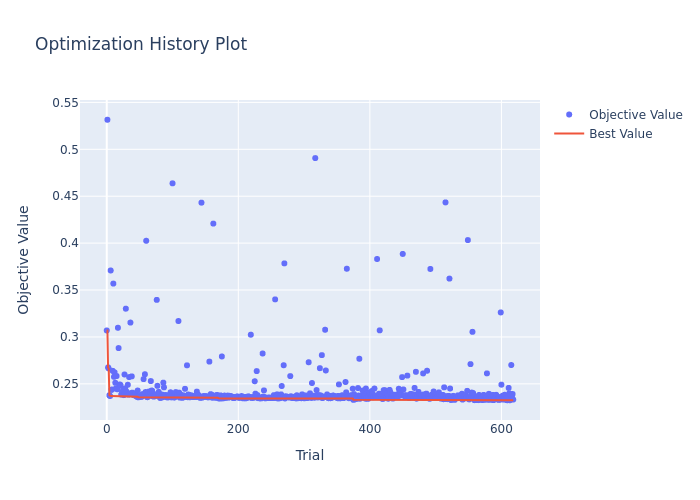

In [11]:
plot_optimization_history(study)

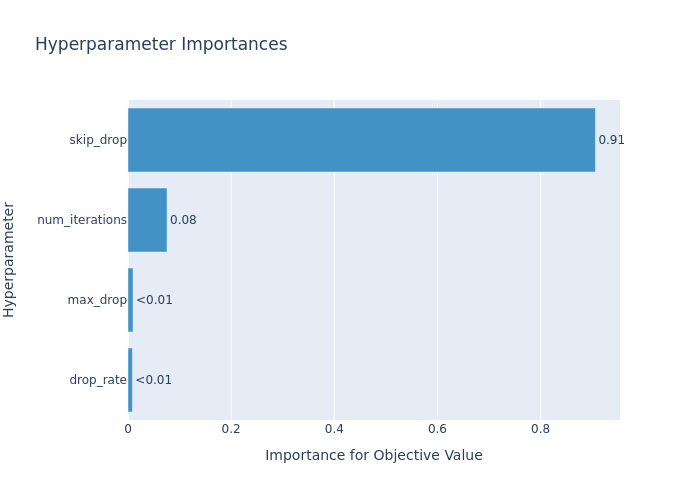

In [12]:
plot_param_importances(study)

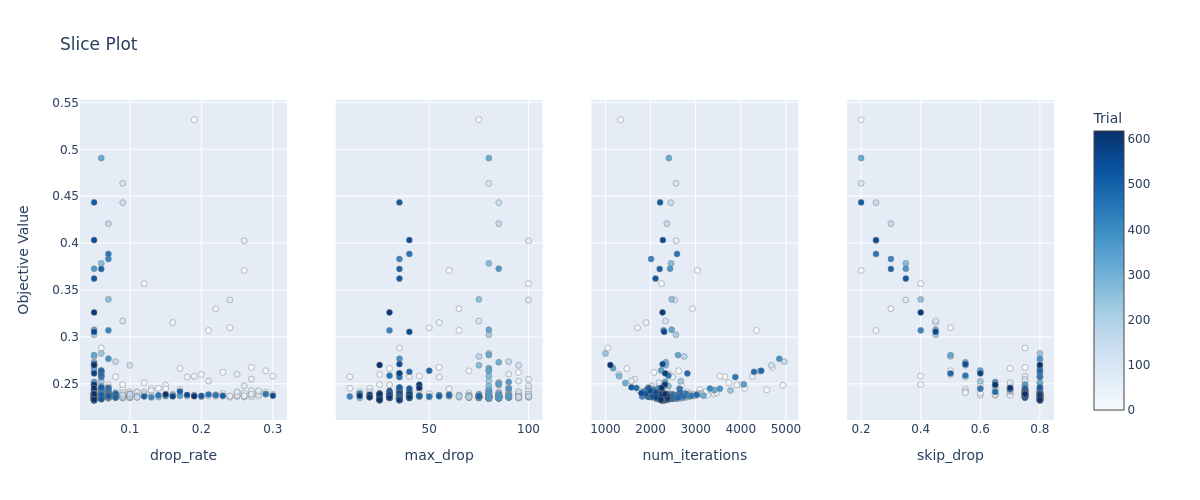

In [13]:
plot_slice(study)

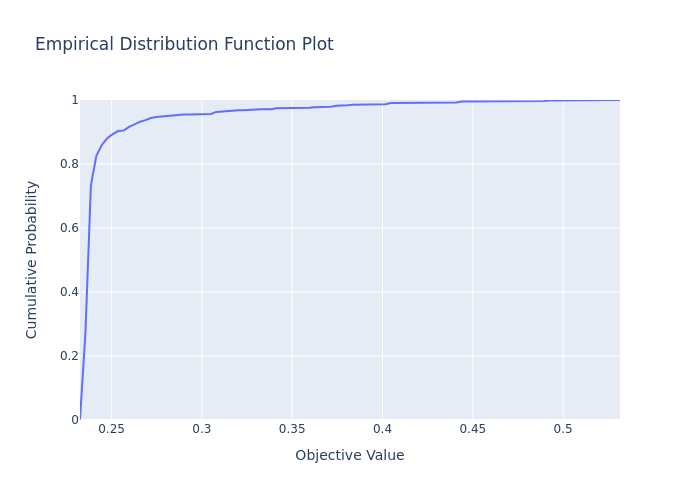

In [14]:
plot_edf(study)

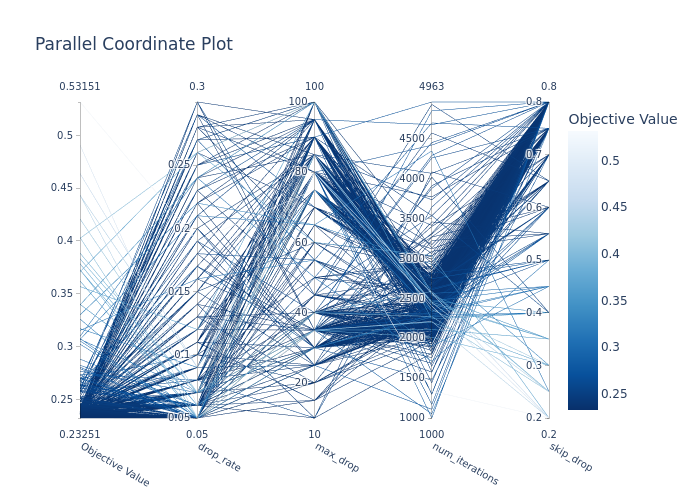

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
#best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
#best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'binary',
 'boosting': 'dart',
 'metric': 'None',
 'learning_rate': 0.005,
 'max_bin': 63,
 'num_leaves': 7,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'feature_fraction': 0.75,
 'lambda_l1': 0.00020196676966216634,
 'lambda_l2': 2.3627262174517976e-09,
 'min_data_in_leaf': 13,
 'min_gain_to_split': 0.0007626326850799573,
 'path_smooth': 2.652521741711401e-09,
 'bagging_freq': 1,
 'pos_bagging_fraction': 1,
 'neg_bagging_fraction': 0.21218074656188604,
 'drop_rate': 0.05,
 'max_drop': 25,
 'num_iterations': 2244,
 'skip_drop': 0.8}

***